<a href="https://colab.research.google.com/github/Caleb-Flegel/CS2---Code-Example/blob/master/Two_Slit_Bright_Light.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Partner: Zach Washburn

Date: 9/20/2022

# Objectives
* To measure both of the slit widths in the double slit slide using
their respective single-slit diffraction patterns.
* To determine the laser wavelength using by fitting the Fraunhofer
model for two-slit interference to the observed intensity pattern.


# Install and import libraries

In [1]:
!pip install whit-phys-util 1>/dev/null
!pip install xlrd --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 1.9 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import whit_phys_util as buc

Mounted at /content/drive


# Connect to GitHub

In [3]:
repo = buc.local_repository("https://github.com/PS251-FA22/two-slit-bright-1b")

Cloning repository from GitHub.


# Equipment

| Description | Manufacturer | Model | ID or SN |
| ----------- | ------------ | ----- | -------- |
| Two-slit interference, one-photon-at-a-time apparatus | TeachSpin | TWS 2-A | TWS 383 |
| multimeter | Fluke | 179 | 58870154 |


# Slit-blocker positions
* Far slit unblocked: 4.35 mm
* Both unblocked: 5.65 mm
* Near slit unblocked: 6.09 mm

In [4]:
distanceToDetector = 19100 # distance from double-slit to detector in mm

19100 mm

# Key landmarks in the interference pattern

| Label | Location (mm) | Photodiode Voltage (V) | 
| ----- | ------------- | ---------------------- |
|$\mathrm{3_f}$ | 3.41 | 0.600 |
|$\mathrm{2_f}$ | 4.21 | 1.549 |
|$\mathrm{1_f}$ | 5.15 | 2.498 |
|$0$            | 5.81 | 2.809 | 
|$\mathrm{1_n}$ | 6.72 | 2.498 |
|$\mathrm{2_n}$ | 7.50 | 1.521 |
|$\mathrm{3_n}$ | 8.26 | 0.588 |

We encountered good differences in volts and location between the three peaks we measured in either direction of the maximum. One possible issues is that our peak voltage is lower than it ideally should be. 

# Import Data

In [5]:
df_near = pd.read_excel("Two Slit Bright Data.xlsx", "Near Slit Only")
df_far = pd.read_excel("Two Slit Bright Data.xlsx", "Far Slit Only")
df_both = pd.read_excel("Two Slit Bright Data.xlsx", "Both Slits")

In [6]:
x = df_near['Location (mm)'] - 5.81
V_near = df_near['Photodiode Voltage (V)']
V_far = df_far['Photodiode Voltage (V)']
V_both = df_both['Photodiode Voltage (V)']

# Single Slit Diffraction

In [7]:
def I_ss(x, I0, a, x0): 
  wavelength = 0.000670 # 670 nm converted to mm
  q = np.arctan((x-x0) / distanceToDetector)
  return I0*np.sinc( a*np.sin(q)/wavelength )**2


In [38]:
param1, far = curve_fit(I_ss, df_far['Location (mm)'], df_far['Photodiode Voltage (V)'], p0=[.736, 3.5, 5.4])
df_far['Best fit'] = I_ss(df_far['Location (mm)'], *param1)

In [39]:
param2, near = curve_fit(I_ss, df_near['Location (mm)'], df_near['Photodiode Voltage (V)'], p0=[.826, 3.4, 6.4])
df_near['Best fit'] = I_ss(df_near['Location (mm)'], *param2)

In [40]:
from whit_phys_util.pretty_fit import fitTable
fitTable_far = buc.fitTable(param1,far,paramLabels=['I0', 'a', 'x0'])
fitTable_far

,I0,a,x0
value,0.735945,3.534052,5.422231
uncertainty,0.001084,0.010065,0.003032


In [41]:
fitTable_near = buc.fitTable(param2, near, paramLabels=['I0','a','x0'])
fitTable_near

,I0,a,x0
value,0.825903,3.432392,6.433024
uncertainty,0.003263,0.029836,0.010795


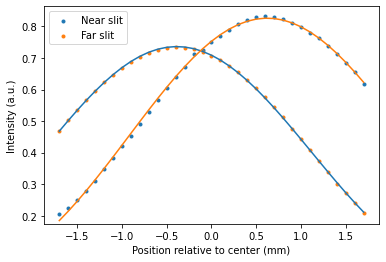

In [42]:
fig_ss, ax_ss = plt.subplots();

ax_ss.scatter(x, V_near, marker='.', label="Near slit");
ax_ss.scatter(x, V_far, marker='.', label="Far slit");

ax_ss.set_xlabel("Position relative to center (mm)");
ax_ss.set_ylabel("Intensity (a.u.)");
ax_ss.legend();
ax_ss.set_xlim();
ax_ss.set_ylim();

ax_ss.plot(x, df_far['Best fit']);
ax_ss.plot(x, df_near['Best fit']);

## Fits results


### Far slit
* $I_0 = 0.735945	±0.001084$
* $a = (3.534052±0.010065)\ \mathrm{mm}$
* $x_0 = (5.422231 ± 0.003032)\ \mathrm{mm}$
* The 95% confidence interval for the slit width is 3.524 to 3.544 mm.

### Near slit
* $I_0 = 0.825903	± 0.003263$
* $a = (3.432392±0.029836)\ \mathrm{mm}$
* $x_0 = (6.433024 ± 0.010795)\ \mathrm{mm}$
* The 95% confidence interval for the slit width is 3.402 to 3.462 mm.

### Comparison
* The slit witdh confidence intervals do not overlap.

* The slit widths defer by 2.9%.
* The intensities defer by 12.4%.



# Two-slit interference

In [66]:
def I_ts(x, I0, a, wavelength, x0, dI):
    d = 0.406 # mm 
    q = np.arctan((x-x0)/distanceToDetector)
    I2s = I0*np.sinc(a*np.sin(q)/wavelength)**2*np.cos(np.pi*d*np.sin(q)/wavelength)**2
    return I2s + dI

In [121]:
param3, both = curve_fit(I_ts, x, df_both['Photodiode Voltage (V)'], p0=[3.5, .1, .000670, .1, .1])

In [120]:
fitTable_both = buc.fitTable(param3,both,paramLabels=['I0', 'a', 'wavelength', 'x0', 'dI'])
fitTable_both

/usr/local/lib/python3.7/dist-packages/whit_phys_util/pretty_fit.py:22: RuntimeWarning: invalid value encountered in sqrt
  return pd.DataFrame(data = [fitParam, ci_factor*np.sqrt(np.diagonal(fitCov))], columns = paramLabels, index = ['value', 'uncertainty'])


,I0,a,wavelength,x0,dI
value,11.591163,-17333.500753,2.597567,-4.022228,0.977810
uncertainty,17.648231,NaN,NaN,1.483132,0.494281


In [112]:
t_fit = np.linspace(-2,2,500);
t_bestFit = I_ts(t_fit, *param3)

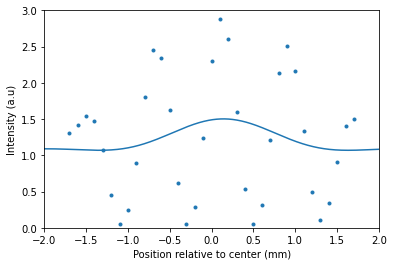

In [116]:
fig_ts, ax_ts = plt.subplots();

ax_ts.scatter(x, V_both, marker = '.', label= "Both slits");
ax_ts.set_xlim(-2,2);
ax_ts.set_ylim(0,3);
ax_ts.set_xlabel("Position relative to center (mm)");
ax_ts.set_ylabel("Intensity (a.u)");

ax_ts.plot(t_fit, t_bestFit);

The laser specifications were that its wavelength was between 665 and 675 nm. The calculated 95% confidence interval for the wavelength is ???? to ???? nm so this falls ?inside/outside? the specified range.

The manufacturer's specifications were that the slit width was 0.1 mm. The calculated 95% confidence interval for the slit width is ???? to ???? mm so this falls ?inside/outside? the specified range.


# Reflection

3) In our single slit experiments, we found that the far slit recieved more light than the near slit. This is likely due to imperfections in how we calibrated the slights and/or light source. This manifested on the double slit graph by shifting the maximum intensity towards the far slit relative to the center. This makes sense as larger proportion of the light in the double slit experiment would come from the fat slit, which is on the side of the offset from the center. 

4) We did fairly well in finding the center location. While $x_0$ was not exactly 0, it was small enough to not massively impact our graph.

5) 